1. Определить бизнес-цели
Бизнес-цели:
    а. Прогнозирование цены страховки
    б. Оценка влияния данных страхователя на цену страховки

2. Определить цели технического проета для каждой бизнес-цели
    а. Построить можедь, которая на основе данных страхователя будет предсказывать цену страховки
    б. Провести анализ для выявления факторов, которые наиболее сильно влияют на итоговую цену страховки

3. Подготовка данных

In [592]:
import pandas as pd
df = pd.read_csv("../dataset.csv")
print(df.shape[0])

2772


данных достаточно чтобы шумы усреднились

In [593]:
print("было ", df.shape[0])
for column in df.select_dtypes(include=['int', 'float']).columns:
    mean = df[column].mean()
    std_dev = df[column].std()
    print(column, mean, std_dev)
    
    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev
    
    df = df[(df[column] <= upper_bound) & (df[column] >= lower_bound)]
    
print("стало ", df.shape[0])
df = df.reset_index(drop=True)

было  2772
age 39.10966810966811 14.081459420836477
bmi 30.70134920634921 6.1294486949652205
children 1.1026753434562546 1.2157555494600176
charges 13325.498588795157 12200.175109274192
стало  2710


были устранены выбросы, отобранные по правилу трех сигм

In [594]:
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


Пропущенных значений нет

4. Разбиение на выборки

In [595]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=52)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=52)

print(train_df.shape[0], val_df.shape[0], test_df.shape[0])
print(df.shape[0], train_df.shape[0] + val_df.shape[0] + test_df.shape[0])

test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

1897 406 407
2710 2710


данные были разделены на обучающую (70%), контрольную (15%) и тестовую (15%) выборки

5. Оценка сбалансированности выборок

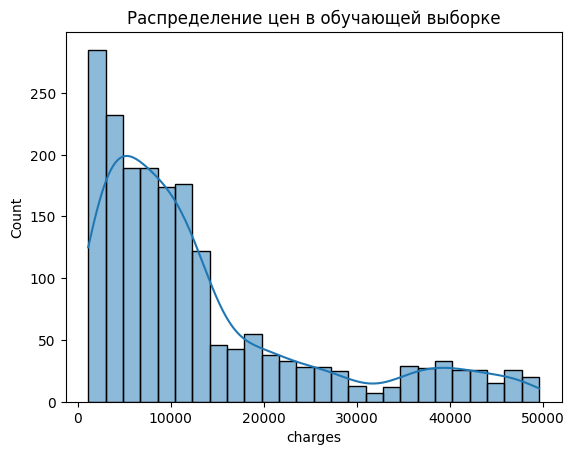

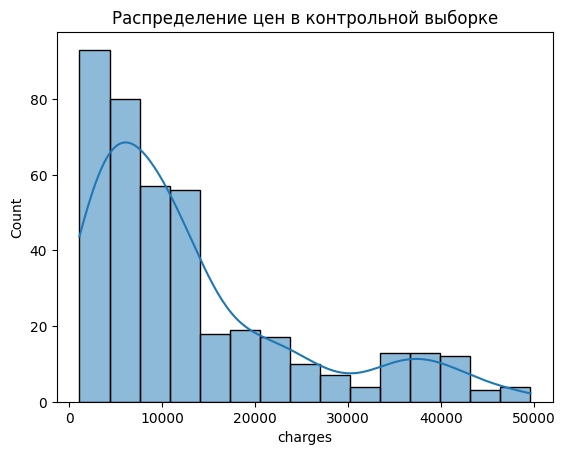

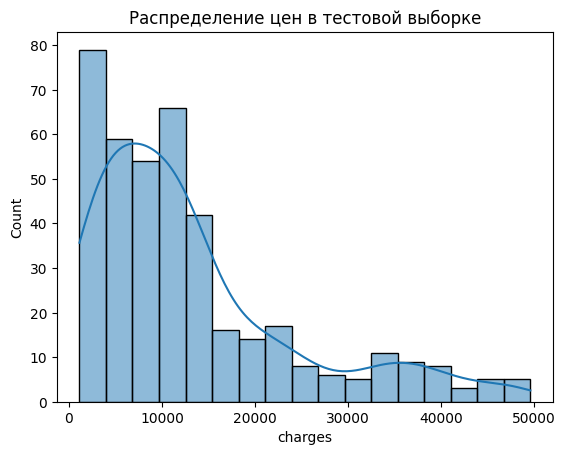

In [596]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw(data, title):
    sns.histplot(data['charges'], kde=True)
    plt.title(title)
    plt.show()
    
draw(train_df, 'Распределение цен в обучающей выборке')
draw(val_df, 'Распределение цен в контрольной выборке')
draw(test_df, 'Распределение цен в тестовой выборке')

6,7. Конструирование признаков

In [597]:
print(df['region'].unique())
print(df['children'].unique())

from sklearn.preprocessing import OneHotEncoder
import numpy as np

encoder = OneHotEncoder(sparse_output=False, drop="first")

encoded_values = encoder.fit_transform(train_df[["smoker", "sex", "region", "children"]])
encoded_columns = encoder.get_feature_names_out(["smoker", "sex", "region", "children"])
encoded_values_df = pd.DataFrame(encoded_values, columns=encoded_columns)
train_df = pd.concat([train_df, encoded_values_df], axis=1)

encoded_values = encoder.fit_transform(test_df[["smoker", "sex", "region", "children"]])
encoded_columns = encoder.get_feature_names_out(["smoker", "sex", "region", "children"])
encoded_values_df = pd.DataFrame(encoded_values, columns=encoded_columns)
test_df = pd.concat([test_df, encoded_values_df], axis=1)

encoded_values = encoder.fit_transform(val_df[["smoker", "sex", "region", "children"]])
encoded_columns = encoder.get_feature_names_out(["smoker", "sex", "region", "children"])
encoded_values_df = pd.DataFrame(encoded_values, columns=encoded_columns)
val_df = pd.concat([val_df, encoded_values_df], axis=1)

print(test_df.columns)
print(val_df.columns)
print(train_df.columns)

['southwest' 'southeast' 'northwest' 'northeast']
[0 1 3 2 4]
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'smoker_yes', 'sex_male', 'region_northwest', 'region_southeast',
       'region_southwest', 'children_1', 'children_2', 'children_3',
       'children_4'],
      dtype='object')
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'smoker_yes', 'sex_male', 'region_northwest', 'region_southeast',
       'region_southwest', 'children_1', 'children_2', 'children_3',
       'children_4'],
      dtype='object')
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'smoker_yes', 'sex_male', 'region_northwest', 'region_southeast',
       'region_southwest', 'children_1', 'children_2', 'children_3',
       'children_4'],
      dtype='object')


Было совершено унитарное кодирование признаков Пол (sex), Курильщик (smoker) и Регион (region). Полученные признаки были добавлены в исходный сет.

In [598]:
print('age', min(df['age']), max(df['age']))
#print('charges', min(df['charges']), max(df['charges']))
print('bmi', min(df['bmi']), max(df['bmi']))

labels_age = ['young', 'middle-aged', 'old']
labels_bmi = ['underweight', 'normal weight', 'overweight']
#labels_charges = ['low_charges', 'medium_charges', 'high_charges']

hist_age, bins_age = np.histogram(test_df['age'], bins = [0, 27, 45, 100])
age_df = pd.concat([test_df['age'], pd.cut(test_df['age'], list(bins_age), labels = labels_age)], axis=1)
test_df['age_category'] = pd.cut(test_df['age'], bins=bins_age, labels=labels_age)

hist_bmi, bins_bmi = np.histogram(test_df['bmi'], bins = [0, 18.5, 25, 100])
bmi_df = pd.concat([test_df['bmi'], pd.cut(test_df['bmi'], list(bins_bmi), labels = labels_bmi)], axis=1)
test_df['bmi_category'] = pd.cut(test_df['bmi'], bins=bins_bmi, labels=labels_bmi)

hist_age, bins_age = np.histogram(train_df['age'], bins = [0, 27, 45, 100])
age_df = pd.concat([train_df['age'], pd.cut(train_df['age'], list(bins_age), labels = labels_age)], axis=1)
train_df['age_category'] = pd.cut(train_df['age'], bins=bins_age, labels=labels_age)

hist_bmi, bins_bmi = np.histogram(train_df['bmi'], bins = [0, 18.5, 25, 100])
bmi_df = pd.concat([train_df['bmi'], pd.cut(train_df['bmi'], list(bins_bmi), labels = labels_bmi)], axis=1)
train_df['bmi_category'] = pd.cut(train_df['bmi'], bins=bins_bmi, labels=labels_bmi)

hist_age, bins_age = np.histogram(val_df['age'], bins = [0, 27, 45, 100])
age_df = pd.concat([val_df['age'], pd.cut(val_df['age'], list(bins_age), labels = labels_age)], axis=1)
val_df['age_category'] = pd.cut(val_df['age'], bins=bins_age, labels=labels_age)

hist_bmi, bins_bmi = np.histogram(val_df['bmi'], bins = [0, 18.5, 25, 100])
bmi_df = pd.concat([val_df['bmi'], pd.cut(val_df['bmi'], list(bins_bmi), labels = labels_bmi)], axis=1)
val_df['bmi_category'] = pd.cut(val_df['bmi'], bins=bins_bmi, labels=labels_bmi)

category_counts = val_df['bmi_category'].value_counts()
print(category_counts)
print('========================')
category_counts = test_df['bmi_category'].value_counts()
print(category_counts)
print('========================')
category_counts = train_df['bmi_category'].value_counts()
print(category_counts)

age 18 64
bmi 15.96 49.06
bmi_category
overweight       335
normal weight     66
underweight        5
Name: count, dtype: int64
bmi_category
overweight       332
normal weight     70
underweight        5
Name: count, dtype: int64
bmi_category
overweight       1543
normal weight     324
underweight        30
Name: count, dtype: int64


Была выполнена дискретизация числовых признаков Индекс массы тела (bmi) и Возраст (age)

In [599]:
train_df['parent_yes'] = train_df['children'] > 0
train_df['parent_yes'] = train_df['parent_yes'].map({True: 1.0, False: 0.0})

test_df['parent_yes'] = test_df['children'] > 0
test_df['parent_yes'] = test_df['parent_yes'].map({True: 1.0, False: 0.0})

val_df['parent_yes'] = val_df['children'] > 0
val_df['parent_yes'] = val_df['parent_yes'].map({True: 1.0, False: 0.0})

print(train_df['parent_yes'].head(20))
print('========================')
print(test_df['parent_yes'].head(20))
print('========================')
print(val_df['parent_yes'].head(20))

0     1.0
1     1.0
2     0.0
3     0.0
4     1.0
5     0.0
6     0.0
7     0.0
8     1.0
9     1.0
10    0.0
11    0.0
12    1.0
13    0.0
14    0.0
15    0.0
16    1.0
17    1.0
18    1.0
19    0.0
Name: parent_yes, dtype: float64
0     1.0
1     1.0
2     0.0
3     1.0
4     0.0
5     1.0
6     0.0
7     0.0
8     1.0
9     0.0
10    1.0
11    1.0
12    0.0
13    0.0
14    0.0
15    1.0
16    1.0
17    0.0
18    1.0
19    1.0
Name: parent_yes, dtype: float64
0     1.0
1     0.0
2     1.0
3     1.0
4     1.0
5     0.0
6     0.0
7     1.0
8     0.0
9     1.0
10    0.0
11    1.0
12    1.0
13    0.0
14    1.0
15    1.0
16    1.0
17    0.0
18    0.0
19    1.0
Name: parent_yes, dtype: float64


Был выполнен ручной синтез признака Родитель, на основе того, есть ли дети у страхователя или нет

In [600]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
test_df['age_norm'] = scaler.fit_transform(test_df[['age']])
print(test_df['age_norm'].head(10))
print('========================')
train_df['age_norm'] = scaler.fit_transform(train_df[['age']])
print(train_df['age_norm'].head(10))
print('========================')
val_df['age_norm'] = scaler.fit_transform(val_df[['age']])
print(val_df['age_norm'].head(10))

0    0.695652
1    0.500000
2    0.239130
3    0.565217
4    0.978261
5    0.304348
6    0.847826
7    0.630435
8    0.804348
9    0.173913
Name: age_norm, dtype: float64
0    0.586957
1    0.413043
2    0.847826
3    0.956522
4    0.521739
5    0.869565
6    0.021739
7    0.130435
8    0.565217
9    0.500000
Name: age_norm, dtype: float64
0    0.217391
1    0.173913
2    0.760870
3    0.108696
4    0.326087
5    0.065217
6    0.282609
7    0.260870
8    0.152174
9    0.565217
Name: age_norm, dtype: float64


Было выполнено маштабирование признака Возраст (age) на основе нормировки.

In [601]:
scaler = preprocessing.StandardScaler()
train_df['age_stand'] = scaler.fit_transform(train_df[['age']])
print(train_df['age_stand'].head(10))
print('========================')
test_df['age_stand'] = scaler.fit_transform(test_df[['age']])
print(test_df['age_stand'].head(10))
print('========================')
val_df['age_stand'] = scaler.fit_transform(val_df[['age']])
print(val_df['age_stand'].head(10))

0    0.414950
1   -0.153961
2    1.268317
3    1.623887
4    0.201608
5    1.339431
6   -1.434012
7   -1.078443
8    0.343836
9    0.130494
Name: age_stand, dtype: float64
0    0.727622
1    0.101529
2   -0.733262
3    0.310226
4    1.631978
5   -0.524564
6    1.214583
7    0.518924
8    1.075451
9   -0.941960
Name: age_stand, dtype: float64
0   -0.766548
1   -0.907530
2    0.995731
3   -1.119003
4   -0.414092
5   -1.259986
6   -0.555074
7   -0.625565
8   -0.978021
9    0.361310
Name: age_stand, dtype: float64


Было выполнено маштабирование признака Возраст (age) на основе стандартизации.

8. Использование Featuretools

In [602]:
import featuretools as ft

es = ft.EntitySet(id='insurance')

es = es.add_dataframe(dataframe_name="insurance_data", dataframe=df, index='index')

agg_primitives = ["sum", "mean", "median", "std", "max", "min", "count"]
trans_primitives = ["add_numeric", "multiply_numeric", "divide_numeric", "subtract_numeric"]

feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name='insurance_data',
    agg_primitives=agg_primitives,
    trans_primitives=trans_primitives,
    max_depth=2
)
feature_matrix

c:\ulstu\mii\AIM-PIbd-31-Barsukov-P-O\aimenv\Lib\site-packages\featuretools\entityset\entityset.py:1733: UserWarning: index index not found in dataframe, creating new integer column
  warnings.warn(
c:\ulstu\mii\AIM-PIbd-31-Barsukov-P-O\aimenv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\ulstu\mii\AIM-PIbd-31-Barsukov-P-O\aimenv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\ulstu\mii\AIM-PIbd-31-Barsukov-P-O\aimenv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To en

age     sex     bmi  children  smoker     region      charges  \
index                                                                  
0       19  female  27.900         0    True  southwest  16884.92400   
1       18    male  33.770         1   False  southeast   1725.55230   
2       28    male  33.000         3   False  southeast   4449.46200   
3       33    male  22.705         0   False  northwest  21984.47061   
4       32    male  28.880         0   False  northwest   3866.85520   
...    ...     ...     ...       ...     ...        ...          ...   
2705    47  female  45.320         1   False  southeast   8569.86180   
2706    21  female  34.600         0   False  southwest   2020.17700   
2707    19    male  26.030         1    True  northwest  16450.89470   
2708    23    male  18.715         0   False  northwest  21595.38229   
2709    54    male  31.600         0   False  southwest   9850.43200   

       age + bmi  age + charges  age + children  ...  age * children  \
index                                            ...                   
0         46.900    16903.92400            19.0  ...             0.0   
1         51.770     1743.55230            19.0  ...            18.0   
2         61.000     4477.46200            31.0  ...            84.0   
3         55.705    22017.47061            33.0  ...             0.0   
4         60.880     3898.85520            32.0  ...             0.0   
...          ...            ...             ...  ...             ...   
2705      92.320     8616.86180            48.0  ...            47.0   
2706      55.600     2041.17700            21.0  ...             0.0   
2707      45.030    16469.89470            20.0  ...            19.0   
2708      41.715    21618.38229            23.0  ...             0.0   
2709      85.600     9904.43200            54.0  ...             0.0   

       bmi * charges  bmi * children  charges * children  age - bmi  \
index                                                                 
0      471089.379600            0.00              0.0000     -8.900   
1       58271.901171           33.77           1725.5523    -15.770   
2      146832.246000           99.00          13348.3860     -5.000   
3      499157.405200            0.00              0.0000     10.295   
4      111674.778176            0.00              0.0000      3.120   
...              ...             ...                 ...        ...   
2705   388386.136776           45.32           8569.8618      1.680   
2706    69898.124200            0.00              0.0000    -13.600   
2707   428216.789041           26.03          16450.8947     -7.030   
2708   404157.579557            0.00              0.0000      4.285   
2709   311273.651200            0.00              0.0000     22.400   

       age - charges  age - children  bmi - charges  bmi - children  \
index                                                                 
0       -16865.92400            19.0   -16857.02400          27.900   
1        -1707.55230            17.0    -1691.78230          32.770   
2        -4421.46200            25.0    -4416.46200          30.000   
3       -21951.47061            33.0   -21961.76561          22.705   
4        -3834.85520            32.0    -3837.97520          28.880   
...              ...             ...            ...             ...   
2705     -8522.86180            46.0    -8524.54180          44.320   
2706     -1999.17700            21.0    -1985.57700          34.600   
2707    -16431.89470            18.0   -16424.86470          25.030   
2708    -21572.38229            23.0   -21576.66729          18.715   
2709     -9796.43200            54.0    -9818.83200          31.600   

       charges - children  
index                      
0             16884.92400  
1              1724.55230  
2              4446.46200  
3             21984.47061  
4              3866.85520  
...                   ...  
2705           8568.86180  
2706           2020.17700  
2707 

Были сконструированы признаки с помощью Featuretools

Index(['age', 'bmi', 'children', 'smoker_yes', 'sex_male', 'region_northwest',
       'region_southeast', 'region_southwest', 'children_1', 'children_2',
       'children_3', 'children_4', 'parent_yes', 'age_norm', 'age_stand'],
      dtype='object')
0.02249455451965332 33039788.648656577 0.7496335938888106


Text(0, 0.5, 'Прогнозируемая цена')

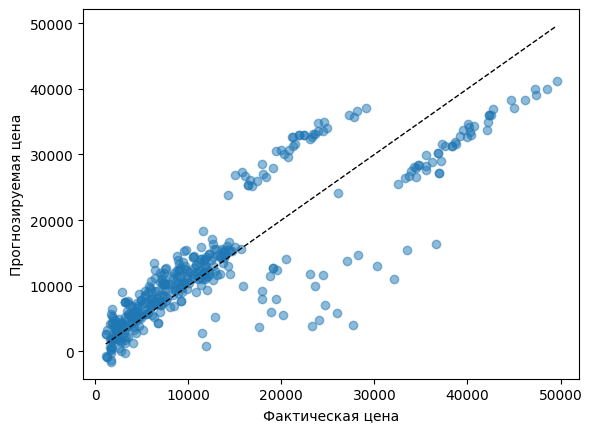

In [603]:
train_X = train_df.drop("charges", axis=1)
train_Y = train_df['charges']

test_X = test_df.drop("charges", axis=1)
test_Y = test_df['charges']

val_X = val_df.drop("charges", axis=1)
val_Y = val_df['charges']

train_X = train_X.drop(['smoker', 'sex', 'region', 'age_category', 'bmi_category'], axis=1)
test_X = test_X.drop(['smoker', 'sex', 'region', 'age_category', 'bmi_category'], axis=1)
val_X = val_X.drop(['smoker', 'sex', 'region', 'age_category', 'bmi_category'], axis=1)

print(train_X.columns)

from sklearn.linear_model import LinearRegression
import time 
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()

start_time = time.time()
model.fit(train_X, train_Y)
train_time = time.time() - start_time

val_predictions = model.predict(val_X)
mse = mean_squared_error(val_Y, val_predictions)
r2 = r2_score(val_Y, val_predictions)

print(train_time, mse, r2)

plt.scatter(val_Y, val_predictions, alpha=0.5)
plt.plot([val_Y.min(), val_Y.max()], [val_Y.min(), val_Y.max()], 'k--', lw=1)
plt.xlabel('Фактическая цена')
plt.ylabel('Прогнозируемая цена')

Обученная модель довольно точно предсказывает цены ниже двух тысяч, для цен более двух тысяч модель занижает или завышает цены